In [1]:
from IPython.display import clear_output
!pip install visualkeras
clear_output()

In [2]:
from IPython.display import clear_output
!pip install visualkeras
clear_output()

# Importing dependencies
import os
import random
import warnings 
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import cv2
import visualkeras

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input, Conv2D, Flatten, GlobalAveragePooling2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

SEED = 15
BATCH_SIZE = 32



In [4]:
# Creating main dataframe containing image paths and their classes.
def create_images_list(path):
    full_path = []
    images = os.listdir(path)
    for i in tqdm(images, desc='images'):
        full_path.append(os.path.join(path, i))
    return full_path

data_healthy = create_images_list('C:/Users/dgous/Downloads/Dataset/healthy/healty')
data_down = create_images_list('C:/Users/dgous/Downloads/Dataset/downSyndrome/downSyndrome')

images:   0%|          | 0/1499 [00:00<?, ?it/s]

images:   0%|          | 0/1500 [00:00<?, ?it/s]

In [5]:
# look-up table
disease_classes = {0: 'healthy', 1: 'down'}

data_df = pd.concat([pd.DataFrame({"img": np.array(data_healthy), "label": 0}),
                     pd.DataFrame({"img": np.array(data_down), "label": 1})], ignore_index=True)

data_df = shuffle(data_df).reset_index(drop=True)

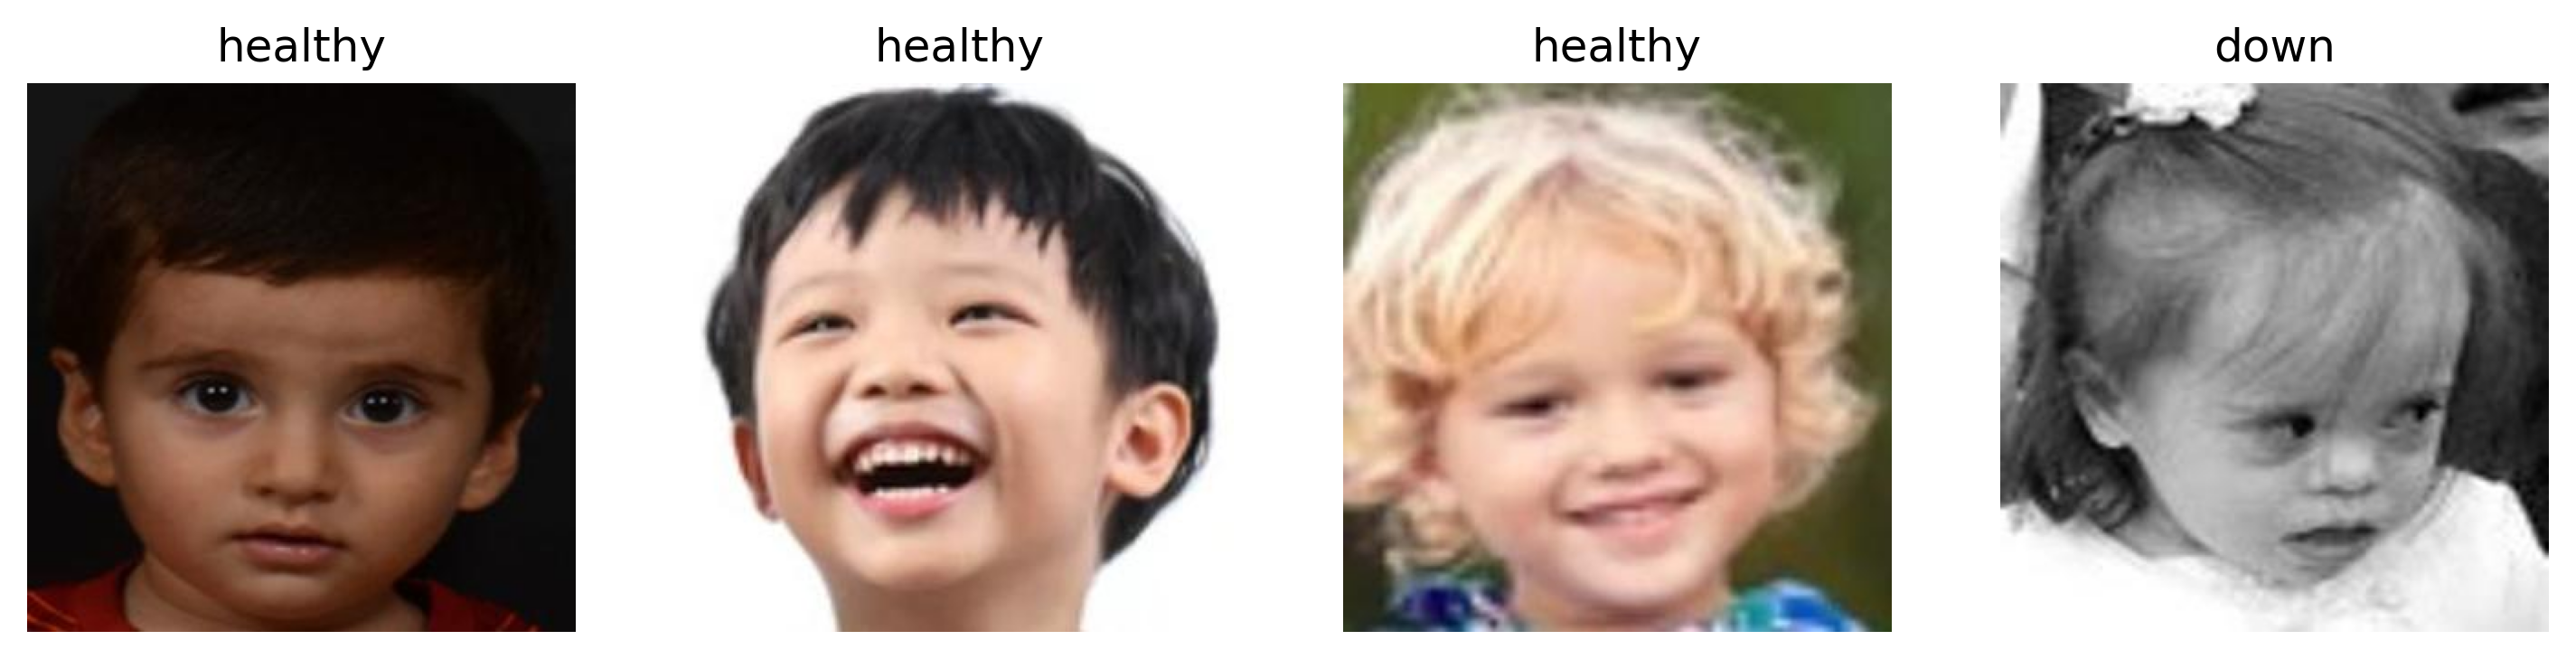

In [6]:
# Creating random samples
def create_img_label_sample(data, index):
    img = cv2.imread(data['img'][index])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    label = disease_classes[data_df['label'][index]]
    return img, label

def create_random_samples(data):
    idx1, idx2, idx3, idx4 = np.random.permutation(data.shape[0])[:4]
    fig, axs = plt.subplots(1, 4, figsize=(12, 5), dpi=300)
    
    for i, idx in enumerate([idx1, idx2, idx3, idx4]):
        img, name = create_img_label_sample(data, idx)
        axs[i].imshow(img)
        axs[i].set_title(name)
        axs[i].axis('off')
    
    plt.show()

# Random samples
create_random_samples(data_df)

In [7]:
# First, define the preprocessing function
def img_preprocessing(x):
    x = tf.image.resize(x, [250, 250])  # Resize the image
    x = x / 255.0  # Normalize the image pixels
    return x

In [8]:
# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data_df['img'], data_df['label'], test_size=0.15, random_state=SEED)

# Further splitting the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=SEED)

print("Train images:", X_train.shape[0])
print("Validation images:", X_val.shape[0])
print("Test images:", X_test.shape[0])

Train images: 2166
Validation images: 383
Test images: 450


In [9]:
# Creating dataset loaders
def img_preprocessing(image, label):
    img = tf.io.read_file(image)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, size=(250, 250))
    img = img / 255.0
    return img, label

train_loader = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = (train_loader.map(img_preprocessing).batch(BATCH_SIZE).shuffle(X_train.shape[0]).prefetch(BATCH_SIZE))

val_loader = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = (val_loader.map(img_preprocessing).batch(BATCH_SIZE).prefetch(BATCH_SIZE))

test_loader = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = (test_loader.map(img_preprocessing).batch(BATCH_SIZE).prefetch(BATCH_SIZE))

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator object with desired augmentation parameters
train_datagen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(preprocessing_function=img_preprocessing)
test_datagen = ImageDataGenerator(preprocessing_function=img_preprocessing)

In [11]:
# CNN Model
In = Input(shape=(250, 250, 3))

conv2 = Conv2D(32, 3, padding='same')(In)
conv2 = BatchNormalization()(conv2)
conv2 = Activation('relu')(conv2)
conv2 = MaxPooling2D(2)(conv2)

conv2 = Conv2D(64, 3, padding='same')(conv2)
conv2 = BatchNormalization()(conv2)
conv2 = Activation('relu')(conv2)
conv2 = MaxPooling2D(2)(conv2)

conv2 = Conv2D(128, 3, padding='same')(conv2)
conv2 = BatchNormalization()(conv2)
conv2 = Activation('relu')(conv2)
conv2 = MaxPooling2D(2)(conv2)

conv2 = Conv2D(256, 3, padding='same')(conv2)
conv2 = BatchNormalization()(conv2)
conv2 = Activation('relu')(conv2)
conv2 = MaxPooling2D(2)(conv2)

pool = GlobalAveragePooling2D()(conv2)
drop = Dropout(0.5)(pool)
dense1 = Dense(64, activation='relu')(drop)
drop = Dropout(0.5)(dense1)
output = Dense(1, activation='sigmoid')(drop)

model = Model(In, output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 250, 250, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 250, 250, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 250, 250, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 250, 250, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 125, 125, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 125, 125, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 125, 125, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 62, 62, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 62, 62, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 62, 62, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 31, 31, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 31, 31, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 31, 31, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 31, 31, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 15, 15, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │              

 Total params: 406,849 (1.55 MB)

 Trainable params: 405,889 (1.55 MB)

 Non-trainable params: 960 (3.75 KB)

In [12]:
# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath='best_weights.weights.h5', save_best_only=True, save_weights_only=True)

In [13]:
# Train the model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10, verbose=1, callbacks=[early_stop, checkpoint])

Epoch 1/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 205s 3s/step - accuracy: 0.6060 - loss: 0.7297 - val_accuracy: 0.5248 - val_loss: 0.7546
Epoch 2/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - accuracy: 0.6572 - loss: 0.6122 - val_accuracy: 0.6188 - val_loss: 0.6538
Epoch 3/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.6794 - loss: 0.6060 - val_accuracy: 0.5431 - val_loss: 0.8531
Epoch 4/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.7021 - loss: 0.5784 - val_accuracy: 0.6397 - val_loss: 0.6632
Epoch 5/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.7199 - loss: 0.5519 - val_accuracy: 0.5457 - val_loss: 0.9768
Epoch 6/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.7079 - loss: 0.5715 - val_accuracy: 0.5587 - val_loss: 1.0963
Epoch 7/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.7224 - loss: 0.5548 - val_accuracy: 0.5979 - val_loss: 0.9153
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.


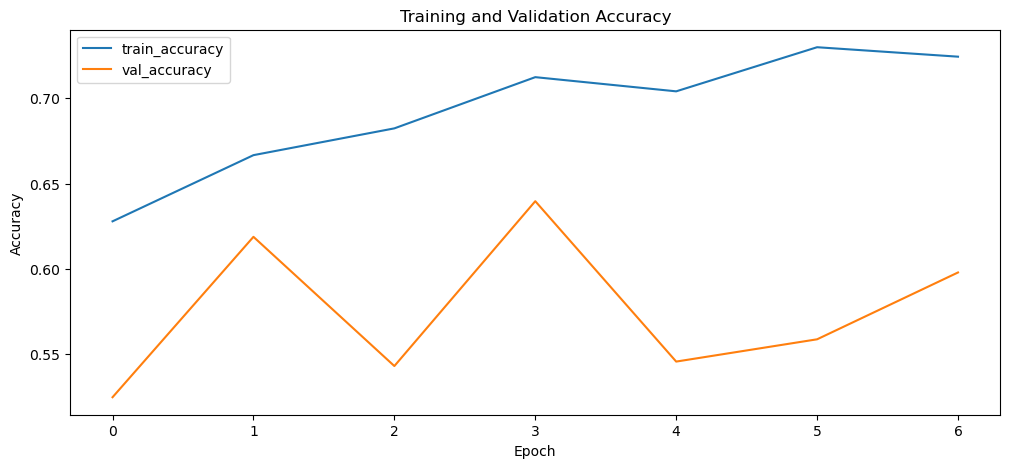

In [14]:
# Plotting training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

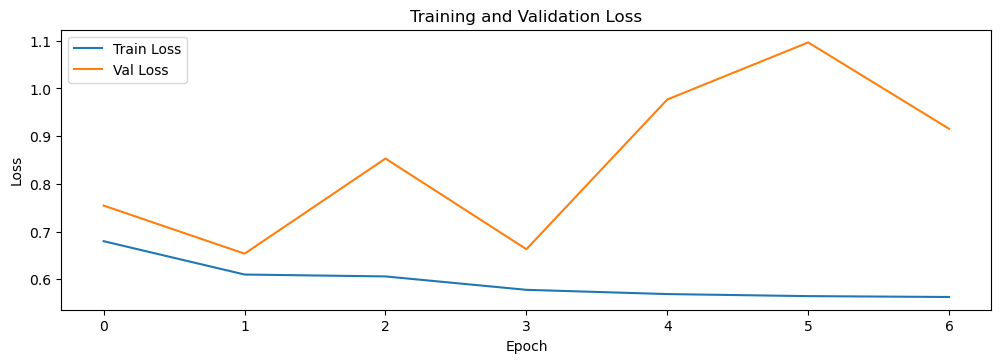

In [15]:
# Plotting training history for loss, precision, recall, and AUC
plt.figure(figsize=(12, 8))

# Plot training and validation loss
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [16]:
# Evaluate the model
model.load_weights('best_weights.weights.h5')
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=0)
print(f'Test Accuracy: {test_accuracy*100:.2f}%')

Test Accuracy: 61.33%


In [17]:
# Making predictions
y_pred = model.predict(test_dataset)
y_pred = (y_pred > 0.5).astype(int)

# Generating classification report
print(classification_report(y_test, y_pred, target_names=['healthy', 'down']))

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 307ms/step
              precision    recall  f1-score   support

     healthy       0.59      0.79      0.67       227
        down       0.67      0.43      0.53       223

    accuracy                           0.61       450
   macro avg       0.63      0.61      0.60       450
weighted avg       0.63      0.61      0.60       450



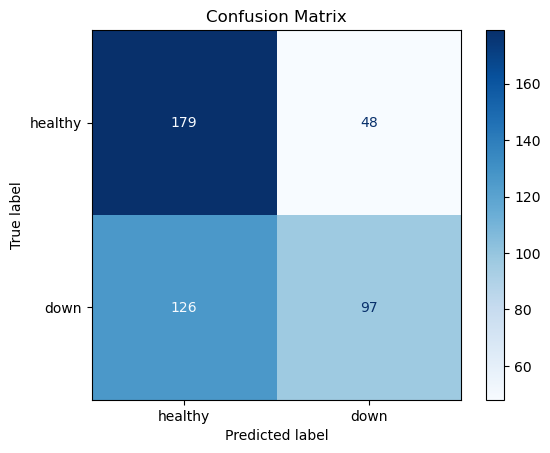

In [18]:
# Generating confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['healthy', 'down'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

In [19]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

# Load the pre-trained MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(250, 250, 3))

# Freeze the base model
base_model.trainable = False

# Create new model on top
inputs = tf.keras.Input(shape=(250, 250, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)  # Dropout for regularization
outputs = Dense(1, activation='sigmoid')(x)  # Binary classification ('downSyndrome' and 'healty')
model = Model(inputs, outputs)

# Compile the model with Adam optimizer and a custom learning rate
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Callbacks for adaptive learning rate and early stopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001, verbose=1)
# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath='best_weights_mobileNetV2.weights.h5', save_best_only=True, save_weights_only=True)


# Train the model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10, verbose=2, callbacks=[reduce_lr, early_stop, checkpoint])

Epoch 1/10
68/68 - 46s - 681ms/step - accuracy: 0.6653 - loss: 0.6128 - precision: 0.6703 - recall: 0.6648 - val_accuracy: 0.7937 - val_loss: 0.4862 - val_precision: 0.8199 - val_recall: 0.7253 - learning_rate: 0.0010
Epoch 2/10
68/68 - 38s - 558ms/step - accuracy: 0.7576 - loss: 0.5024 - precision: 0.7679 - recall: 0.7461 - val_accuracy: 0.8120 - val_loss: 0.4414 - val_precision: 0.7895 - val_recall: 0.8242 - learning_rate: 0.0010
Epoch 3/10
68/68 - 38s - 560ms/step - accuracy: 0.7881 - loss: 0.4662 - precision: 0.7978 - recall: 0.7781 - val_accuracy: 0.8172 - val_loss: 0.4271 - val_precision: 0.7692 - val_recall: 0.8791 - learning_rate: 0.0010
Epoch 4/10
68/68 - 41s - 609ms/step - accuracy: 0.8042 - loss: 0.4346 - precision: 0.8058 - recall: 0.8073 - val_accuracy: 0.8303 - val_loss: 0.3966 - val_precision: 0.8503 - val_recall: 0.7802 - learning_rate: 0.0010
Epoch 5/10
68/68 - 39s - 571ms/step - accuracy: 0.8135 - loss: 0.4196 - precision: 0.8149 - recall: 0.8164 - val_accuracy: 0.838

In [20]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 250, 250, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 8, 8, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │           1,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,261,829 (8.63 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 2,564 (10.02 KB)

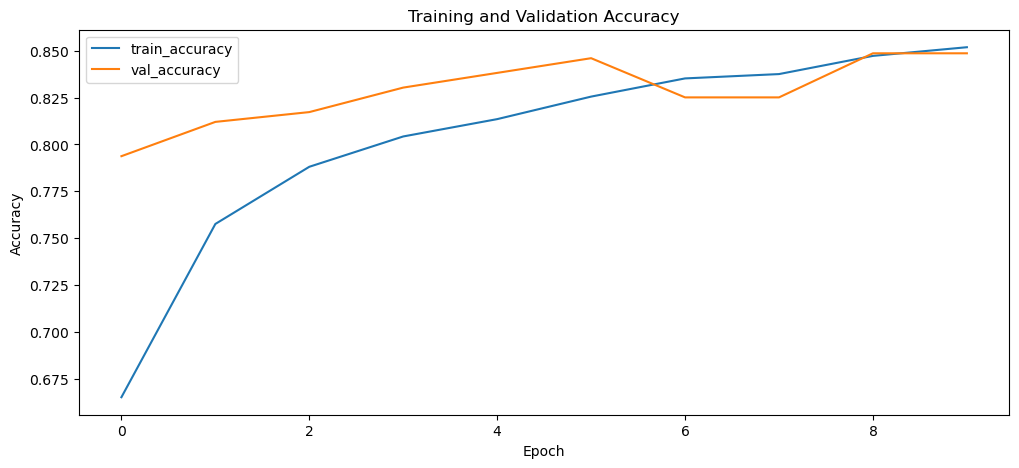

In [21]:
# Plotting training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

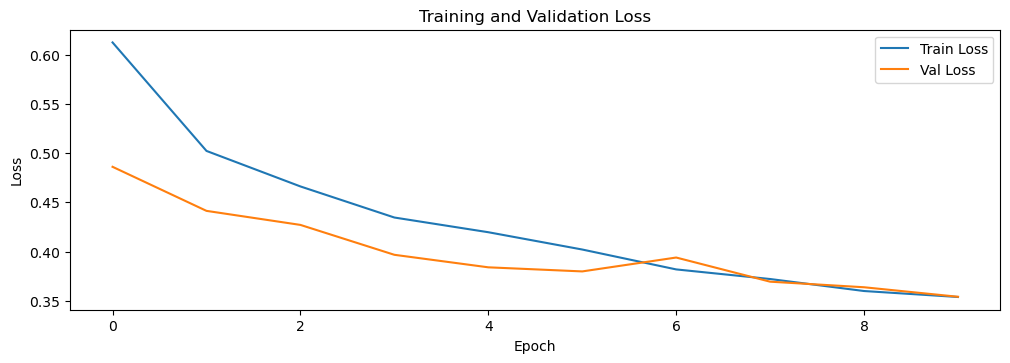

In [22]:
# Plotting training history for loss, precision, recall, and AUC
plt.figure(figsize=(12, 8))

# Plot training and validation loss
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [23]:
# Evaluate the model
model.load_weights('best_weights_mobileNetV2.weights.h5')
test_loss, test_accuracy, *_ = model.evaluate(test_dataset, verbose=2)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

15/15 - 5s - 353ms/step - accuracy: 0.8244 - loss: 0.3842 - precision: 0.8303 - recall: 0.8117
Test Loss: 0.38416773080825806
Test Accuracy: 0.8244444727897644


In [24]:
# Making predictions
y_pred = model.predict(test_dataset)
y_pred = (y_pred > 0.5).astype(int)

# Generating classification report
print(classification_report(y_test, y_pred, target_names=['healthy', 'down']))

15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 445ms/step
              precision    recall  f1-score   support

     healthy       0.82      0.84      0.83       227
        down       0.83      0.81      0.82       223

    accuracy                           0.82       450
   macro avg       0.82      0.82      0.82       450
weighted avg       0.82      0.82      0.82       450



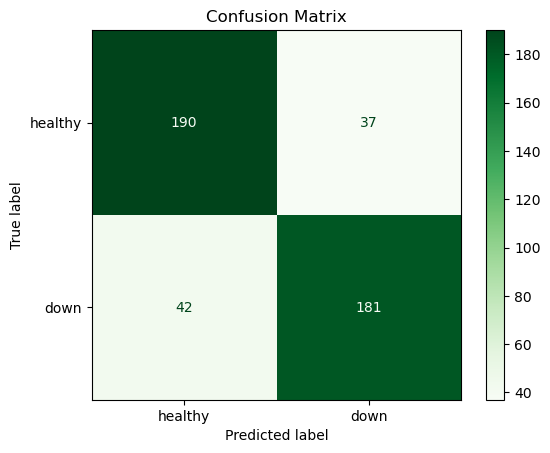

In [25]:
# Generating confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['healthy', 'down'])
disp.plot(cmap='Greens', values_format='d')
plt.title('Confusion Matrix')
plt.show()